In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, rank_int

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
parc_str = 'schaefer'
parc_scale = 200
edge_weight = 'streamlineCount'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

### Setup directory variables

In [4]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [5]:
outputdir = os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/0_get_sample/out


In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


# Load in demographic and symptom data

In [7]:
# LTN and Health Status
health = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/health/n1601_health_20170421.csv'))
# Protocol
prot = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/n1601_pnc_protocol_validation_params_status_20161220.csv'))
# T1 QA
t1_qa = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_t1QaData_20170306.csv'))
# DTI QA
dti_qa = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/dti/n1601_dti_qa_20170301.csv'))
# Rest QA
rest_qa = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/rest/n1601_RestQAData_20170714.csv'))
# Demographics
demog = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/demographics/n1601_demographics_go1_20161212.csv'))
# Brain volume
brain_vol = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_ctVol20170412.csv'))
# GOASSESS Bifactor scores
goassess = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/GO1_clinical_factor_scores_psychosis_split_BIFACTOR.csv'))

# merge
df = health
df = pd.merge(df, prot, on=['scanid', 'bblid']) # prot
df = pd.merge(df, t1_qa, on=['scanid', 'bblid']) # t1_qa
df = pd.merge(df, dti_qa, on=['scanid', 'bblid']) # dti_qa
df = pd.merge(df, rest_qa, on=['scanid', 'bblid']) # rest_qa
df = pd.merge(df, demog, on=['scanid', 'bblid']) # demog
df = pd.merge(df, brain_vol, on=['scanid', 'bblid']) # brain_vol
df = pd.merge(df, goassess, on=['bblid']) # goassess

print(df.shape[0])
df.set_index(['bblid', 'scanid'], inplace = True)

1599


In [8]:
df.head()

,,timepoint_x,smrytrt_psychinpt,psychoactiveMedPsychv2,psychoactiveMedMedicalv2,incidentalFindingExclude,medicalratingExcludev1,healthExcludev2,ltnExcludev2,squeakycleanExclude,psychoactiveMedMedical,...,mprage_antsCT_vol_DeepGrayMatter,mprage_antsCT_vol_BrainStem,mprage_antsCT_vol_Cerebellum,mprage_antsCT_vol_TBV,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
80961,2632,1,0,1,0,0,0,0,1,1,0,...,52141.098450,17099.116230,140667.147488,1.467376e+06,1.946241,1.250946,1.375173,-0.737588,0.845164,-2.437746
80199,2637,1,0,0,0,0,0,0,0,0,0,...,56126.058254,19814.056864,150808.843822,1.590630e+06,1.854055,0.370510,-0.925523,-0.883597,0.130829,0.742890
80179,2643,1,1,1,0,0,0,0,1,1,0,...,38010.047782,16670.210102,136221.640940,1.310120e+06,0.495788,-0.824844,1.762409,1.037908,0.622578,0.950200
81005,2644,1,0,0,0,0,1,1,1,1,0,...,46560.045350,16218.452418,138964.706566,1.455427e+06,0.059965,-1.015043,1.395996,0.373101,1.358093,0.982293
80812,2646,1,0,0,0,0,0,0,0,1,0,...,46874.693698,20525.091818,141902.010418,1.540885e+06,2.080370,0.274750,-1.888498,0.261131,-1.500084,1.584978


# Filter subjects

In [9]:
# 1) Primary sample filter
df = df[df['healthExcludev2'] == 0]
print('N after initial exclusion:', df.shape[0])

# 2) T1 exclusion
df = df[df['t1Exclude'] == 0]
print('N after T1 exclusion:', df.shape[0])

# 3) Diffusion exclusion
df = df[df['b0ProtocolValidationStatus'] == 1]
df = df[df['dti64ProtocolValidationStatus'] == 1]
df = df[df['dti64Exclude'] == 0]
print('N after Diffusion exclusion:', df.shape[0])

N after initial exclusion: 1445
N after T1 exclusion: 1394
N after Diffusion exclusion: 1100


In [10]:
df['dti64QAManualScore'].unique()

array([2., 1.])

In [11]:
np.sum(df['averageManualRating'] == 2)

949

In [12]:
np.sum(df['dti64QAManualScore'] == 2)

675

In [13]:
# Convert age to years
df['ageAtScan1_Years'] = np.round(df.ageAtScan1/12, decimals=1)

In [14]:
# find unique ages
age_unique = np.unique(df.ageAtScan1_Years)
print('There are', age_unique.shape[0], 'unique age points')

There are 144 unique age points


## Symptom dimensions

In [15]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
print(phenos)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


In [16]:
for pheno in phenos:
    if df.loc[:,pheno].isna().any():
        print('NaN replacement: ', pheno)
        x = np.nanmedian(df.loc[:,pheno])
        df.loc[df.loc[:,pheno].isna(),pheno] = x

In [17]:
# Normalize
rank_r = np.zeros(len(phenos),)

for i, pheno in enumerate(phenos):
    # normalize regional metric
#     x = sp.stats.yeojohnson(df.loc[:,pheno])[0]
    x = rank_int(df.loc[:,pheno])
    # check if rank order is preserved
    rank_r[i] = sp.stats.spearmanr(df.loc[:,pheno],x)[0]
    # store normalized version
    df.loc[:,pheno] = x

print(np.sum(rank_r < 1))

0


In [18]:
df.loc[:,phenos].var()

Overall_Psychopathology     0.984011
Psychosis_Positive          0.997019
Psychosis_NegativeDisorg    0.997019
dtype: float64

## Export

In [19]:
header = ['squeakycleanExclude','ageAtScan1', 'ageAtScan1_Years','sex','race2','handednessv2', 'averageManualRating', 'dti64QAManualScore', 'restProtocolValidationStatus', 'restExclude',
          'dti64MeanAbsRMS','dti64MeanRelRMS','dti64MaxAbsRMS','dti64MaxRelRMS','mprage_antsCT_vol_TBV', 'averageManualRating',
          'Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
df.to_csv(os.path.join(outputdir, 'df.csv'), columns = header)

# Plots

In [20]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']

## Age

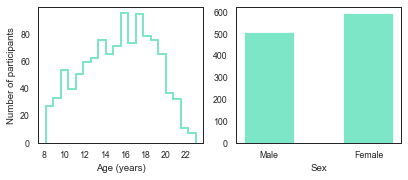

In [21]:
f, axes = plt.subplots(1,2)
f.set_figwidth(6.5)
f.set_figheight(2.5)
colormap = sns.color_palette("pastel", 2)

sns.distplot(df.loc[:,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False,
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[0]), ax = axes[0]);
axes[0].set_xlabel('Age (years)');
axes[0].set_ylabel('Number of participants');
axes[0].set_xticks(np.arange(np.min(np.round(age_unique,0)), np.max(np.round(age_unique,0)), 2))

# set width of bar
barWidth = 0.25

# Sex (1 = male, 2 = female)
y_train = [np.sum(df.loc[:,'sex'] == 1), np.sum(df.loc[:,'sex'] == 2)]
r1 = np.arange(len(y_train))+barWidth/2
r2 = [x + barWidth for x in r1]
axes[1].bar([0,0.5], y_train, width = barWidth, color = cmap[0])
axes[1].set_xlabel('Sex')
# axes[1].set_ylabel('Number of participants')
axes[1].set_xticks([0,0.5])
axes[1].set_xticklabels(['Male', 'Female'])

f.savefig('age_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Symptom dimensions

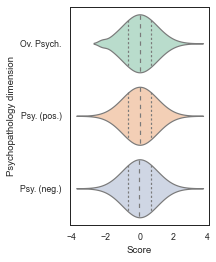

In [22]:
df_rc = pd.melt(df, value_vars = phenos)

f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(4)
ax = sns.violinplot(y='variable', x='value', data=df_rc, split=True, scale='width', inner = 'quartile', orient = 'h', palette = 'Pastel2')
# ax.get_legend().remove()
ax.set_yticklabels(phenos_label_short)
ax.set_ylabel('Psychopathology dimension')
ax.set_xlabel('Score')
f.savefig('symptoms_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Export sample for FC gradients

In [23]:
# 4) rs-fMRI exclusion
df = df[df['restProtocolValidationStatus'] == 1]
df = df[df['restExclude'] == 0]
print('N after rs-fMRI exclusion:', df.shape[0])

N after rs-fMRI exclusion: 926


In [24]:
df.to_csv(os.path.join(outputdir, 'df_gradients.csv'), columns = header)